## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [3]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

## File paths

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [77]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


In [7]:
trans_val_ann.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [8]:
trans_val_ann['info']

{'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'version': 'Caltech Camera Traps - ECCV18',
 'description': 'Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston',
 'year': 2018}

In [9]:
trans_val_ann['categories']

[{'id': 6, 'name': 'bobcat'},
 {'id': 1, 'name': 'opossum'},
 {'id': 30, 'name': 'empty'},
 {'id': 9, 'name': 'coyote'},
 {'id': 3, 'name': 'raccoon'},
 {'id': 11, 'name': 'bird'},
 {'id': 8, 'name': 'dog'},
 {'id': 16, 'name': 'cat'},
 {'id': 5, 'name': 'squirrel'},
 {'id': 10, 'name': 'rabbit'},
 {'id': 7, 'name': 'skunk'},
 {'id': 99, 'name': 'rodent'},
 {'id': 21, 'name': 'badger'},
 {'id': 34, 'name': 'deer'},
 {'id': 33, 'name': 'car'},
 {'id': 51, 'name': 'fox'}]

In [10]:
trans_val_ann['annotations'][0]

{'image_id': '58df680b-23d2-11e8-a6a3-ec086b02610b',
 'category_id': 6,
 'bbox': [1123.7375892857142,
  787.8743750000001,
  284.6749107142857,
  244.2854464285715],
 'id': '19220'}

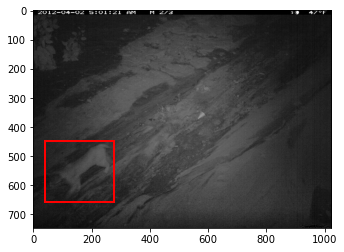

In [76]:
i = 500

boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
         if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
         and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(),cmap="gray")

scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
    boxes[i][0] = torch.round(boxes[i][0] * scale_x)
    boxes[i][1] = torch.round(boxes[i][1] * scale_y)
    boxes[i][2] = torch.round(boxes[i][2] * scale_x)
    boxes[i][3] = torch.round(boxes[i][3] * scale_y)

    boxes[i][2] = boxes[i][0] + boxes[i][2]
    boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Utils

In [20]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [21]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [22]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target

In [87]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

## Pre-trained model

In [27]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [28]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    for param in model.roi_heads.parameters():
        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper, construct the scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [30]:
train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [31]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)   # takes about 1min to run on train data
trans_valid_data = CustomImageDataset(trans_val_ann_path,img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [32]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data
cis_valid_data = CustomImageDataset(cis_val_ann_path,img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [75]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

## Training the model

In [ ]:
# PARAMETERS FOR TRAINING
num_epochs = 10

In [36]:
# TRAIN

all_train_logs = []
all_trans_valid_logs = []
all_cis_valid_logs = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 100 images
    train_logs = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    all_train_logs.append(train_logs)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset after training one epoch

    for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            trans_loss_dict = model(images, targets)
            trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
            all_trans_valid_logs.append(trans_loss_dict)


    for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            cis_loss_dict = model(images, targets)
            cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
            all_cis_valid_logs.append(cis_loss_dict)

C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/12099]  eta: 7:43:14  lr: 0.000001  loss: 0.7607 (0.7607)  loss_classifier: 0.6114 (0.6114)  loss_box_reg: 0.1085 (0.1085)  loss_objectness: 0.0301 (0.0301)  loss_rpn_box_reg: 0.0106 (0.0106)  time: 2.2973  data: 0.0315  max mem: 524
Epoch: [0]  [  100/12099]  eta: 0:28:22  lr: 0.000031  loss: 0.3303 (0.5415)  loss_classifier: 0.1518 (0.3759)  loss_box_reg: 0.1217 (0.1202)  loss_objectness: 0.0157 (0.0375)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1140  data: 0.0287  max mem: 630
Epoch: [0]  [  200/12099]  eta: 0:25:47  lr: 0.000061  loss: 0.2386 (0.4137)  loss_classifier: 0.1054 (0.2463)  loss_box_reg: 0.1160 (0.1208)  loss_objectness: 0.0046 (0.0392)  loss_rpn_box_reg: 0.0036 (0.0074)  time: 0.1265  data: 0.0354  max mem: 630
Epoch: [0]  [  300/12099]  eta: 0:24:43  lr: 0.000091  loss: 0.2515 (0.3639)  loss_classifier: 0.0884 (0.1980)  loss_box_reg: 0.0950 (0.1217)  loss_objectness: 0.0114 (0.0374)  loss_rpn_box_reg: 0.0031 (0.0068)  time: 0.1136  data: 0.0293  m

Epoch: [0]  [ 3300/12099]  eta: 0:16:34  lr: 0.000300  loss: 0.1319 (0.1833)  loss_classifier: 0.0471 (0.0654)  loss_box_reg: 0.0734 (0.0762)  loss_objectness: 0.0074 (0.0334)  loss_rpn_box_reg: 0.0032 (0.0082)  time: 0.1120  data: 0.0288  max mem: 630
Epoch: [0]  [ 3400/12099]  eta: 0:16:23  lr: 0.000300  loss: 0.1259 (0.1825)  loss_classifier: 0.0411 (0.0649)  loss_box_reg: 0.0634 (0.0759)  loss_objectness: 0.0064 (0.0334)  loss_rpn_box_reg: 0.0033 (0.0082)  time: 0.1108  data: 0.0271  max mem: 630
Epoch: [0]  [ 3500/12099]  eta: 0:16:11  lr: 0.000300  loss: 0.1203 (0.1818)  loss_classifier: 0.0469 (0.0644)  loss_box_reg: 0.0512 (0.0754)  loss_objectness: 0.0236 (0.0337)  loss_rpn_box_reg: 0.0027 (0.0083)  time: 0.1103  data: 0.0270  max mem: 630
Epoch: [0]  [ 3600/12099]  eta: 0:15:59  lr: 0.000300  loss: 0.1332 (0.1809)  loss_classifier: 0.0269 (0.0638)  loss_box_reg: 0.0336 (0.0749)  loss_objectness: 0.0144 (0.0339)  loss_rpn_box_reg: 0.0037 (0.0083)  time: 0.1109  data: 0.0270  m

Epoch: [0]  [ 6600/12099]  eta: 0:10:17  lr: 0.000300  loss: 0.0815 (0.1618)  loss_classifier: 0.0254 (0.0537)  loss_box_reg: 0.0407 (0.0662)  loss_objectness: 0.0068 (0.0339)  loss_rpn_box_reg: 0.0018 (0.0080)  time: 0.1108  data: 0.0274  max mem: 630
Epoch: [0]  [ 6700/12099]  eta: 0:10:06  lr: 0.000300  loss: 0.0949 (0.1613)  loss_classifier: 0.0270 (0.0535)  loss_box_reg: 0.0362 (0.0660)  loss_objectness: 0.0065 (0.0338)  loss_rpn_box_reg: 0.0022 (0.0080)  time: 0.1112  data: 0.0273  max mem: 630
Epoch: [0]  [ 6800/12099]  eta: 0:09:55  lr: 0.000300  loss: 0.0958 (0.1607)  loss_classifier: 0.0260 (0.0533)  loss_box_reg: 0.0485 (0.0658)  loss_objectness: 0.0016 (0.0337)  loss_rpn_box_reg: 0.0009 (0.0079)  time: 0.1132  data: 0.0291  max mem: 630
Epoch: [0]  [ 6900/12099]  eta: 0:09:44  lr: 0.000300  loss: 0.0931 (0.1603)  loss_classifier: 0.0337 (0.0531)  loss_box_reg: 0.0469 (0.0656)  loss_objectness: 0.0098 (0.0336)  loss_rpn_box_reg: 0.0018 (0.0080)  time: 0.1135  data: 0.0295  m

Epoch: [0]  [ 9900/12099]  eta: 0:04:06  lr: 0.000300  loss: 0.1144 (0.1513)  loss_classifier: 0.0290 (0.0483)  loss_box_reg: 0.0596 (0.0620)  loss_objectness: 0.0160 (0.0332)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1110  data: 0.0276  max mem: 630
Epoch: [0]  [10000/12099]  eta: 0:03:55  lr: 0.000300  loss: 0.1344 (0.1512)  loss_classifier: 0.0300 (0.0481)  loss_box_reg: 0.0449 (0.0619)  loss_objectness: 0.0157 (0.0333)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1120  data: 0.0283  max mem: 630
Epoch: [0]  [10100/12099]  eta: 0:03:44  lr: 0.000300  loss: 0.0976 (0.1510)  loss_classifier: 0.0243 (0.0480)  loss_box_reg: 0.0452 (0.0617)  loss_objectness: 0.0136 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1123  data: 0.0289  max mem: 630
Epoch: [0]  [10200/12099]  eta: 0:03:32  lr: 0.000300  loss: 0.1219 (0.1509)  loss_classifier: 0.0341 (0.0479)  loss_box_reg: 0.0448 (0.0617)  loss_objectness: 0.0206 (0.0333)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1126  data: 0.0291  m

Epoch: [1]  [ 1000/12099]  eta: 0:20:40  lr: 0.000300  loss: 0.1217 (0.1279)  loss_classifier: 0.0360 (0.0350)  loss_box_reg: 0.0563 (0.0527)  loss_objectness: 0.0171 (0.0320)  loss_rpn_box_reg: 0.0038 (0.0082)  time: 0.1118  data: 0.0279  max mem: 3859
Epoch: [1]  [ 1100/12099]  eta: 0:20:29  lr: 0.000300  loss: 0.1194 (0.1279)  loss_classifier: 0.0305 (0.0349)  loss_box_reg: 0.0485 (0.0526)  loss_objectness: 0.0213 (0.0325)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1120  data: 0.0274  max mem: 3859
Epoch: [1]  [ 1200/12099]  eta: 0:20:18  lr: 0.000300  loss: 0.1173 (0.1280)  loss_classifier: 0.0250 (0.0350)  loss_box_reg: 0.0351 (0.0525)  loss_objectness: 0.0012 (0.0327)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1117  data: 0.0283  max mem: 3859
Epoch: [1]  [ 1300/12099]  eta: 0:20:07  lr: 0.000300  loss: 0.0897 (0.1268)  loss_classifier: 0.0306 (0.0348)  loss_box_reg: 0.0501 (0.0523)  loss_objectness: 0.0040 (0.0320)  loss_rpn_box_reg: 0.0022 (0.0077)  time: 0.1129  data: 0.0287

Epoch: [1]  [ 4300/12099]  eta: 0:14:32  lr: 0.000300  loss: 0.0844 (0.1277)  loss_classifier: 0.0206 (0.0348)  loss_box_reg: 0.0523 (0.0524)  loss_objectness: 0.0034 (0.0325)  loss_rpn_box_reg: 0.0021 (0.0080)  time: 0.1140  data: 0.0296  max mem: 3859
Epoch: [1]  [ 4400/12099]  eta: 0:14:21  lr: 0.000300  loss: 0.1021 (0.1277)  loss_classifier: 0.0305 (0.0348)  loss_box_reg: 0.0531 (0.0523)  loss_objectness: 0.0090 (0.0325)  loss_rpn_box_reg: 0.0020 (0.0080)  time: 0.1107  data: 0.0264  max mem: 3859
Epoch: [1]  [ 4500/12099]  eta: 0:14:10  lr: 0.000300  loss: 0.1020 (0.1278)  loss_classifier: 0.0215 (0.0348)  loss_box_reg: 0.0326 (0.0523)  loss_objectness: 0.0118 (0.0326)  loss_rpn_box_reg: 0.0038 (0.0081)  time: 0.1115  data: 0.0282  max mem: 3859
Epoch: [1]  [ 4600/12099]  eta: 0:13:59  lr: 0.000300  loss: 0.1071 (0.1278)  loss_classifier: 0.0259 (0.0347)  loss_box_reg: 0.0411 (0.0522)  loss_objectness: 0.0029 (0.0328)  loss_rpn_box_reg: 0.0052 (0.0081)  time: 0.1123  data: 0.0291

Epoch: [1]  [ 7600/12099]  eta: 0:08:23  lr: 0.000300  loss: 0.1018 (0.1277)  loss_classifier: 0.0244 (0.0345)  loss_box_reg: 0.0383 (0.0519)  loss_objectness: 0.0105 (0.0333)  loss_rpn_box_reg: 0.0038 (0.0080)  time: 0.1110  data: 0.0279  max mem: 3859
Epoch: [1]  [ 7700/12099]  eta: 0:08:12  lr: 0.000300  loss: 0.1052 (0.1277)  loss_classifier: 0.0242 (0.0344)  loss_box_reg: 0.0360 (0.0519)  loss_objectness: 0.0168 (0.0334)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1121  data: 0.0279  max mem: 3859
Epoch: [1]  [ 7800/12099]  eta: 0:08:01  lr: 0.000300  loss: 0.0996 (0.1276)  loss_classifier: 0.0254 (0.0344)  loss_box_reg: 0.0481 (0.0519)  loss_objectness: 0.0051 (0.0334)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1116  data: 0.0276  max mem: 3859
Epoch: [1]  [ 7900/12099]  eta: 0:07:50  lr: 0.000300  loss: 0.1032 (0.1277)  loss_classifier: 0.0309 (0.0345)  loss_box_reg: 0.0389 (0.0519)  loss_objectness: 0.0154 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1106  data: 0.0273

Epoch: [1]  [10900/12099]  eta: 0:02:14  lr: 0.000300  loss: 0.1118 (0.1270)  loss_classifier: 0.0291 (0.0341)  loss_box_reg: 0.0360 (0.0516)  loss_objectness: 0.0187 (0.0335)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1129  data: 0.0279  max mem: 3859
Epoch: [1]  [11000/12099]  eta: 0:02:03  lr: 0.000300  loss: 0.0931 (0.1269)  loss_classifier: 0.0241 (0.0340)  loss_box_reg: 0.0282 (0.0515)  loss_objectness: 0.0097 (0.0335)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1143  data: 0.0297  max mem: 3859
Epoch: [1]  [11100/12099]  eta: 0:01:51  lr: 0.000300  loss: 0.1200 (0.1269)  loss_classifier: 0.0233 (0.0340)  loss_box_reg: 0.0410 (0.0514)  loss_objectness: 0.0162 (0.0336)  loss_rpn_box_reg: 0.0049 (0.0079)  time: 0.1127  data: 0.0283  max mem: 3859
Epoch: [1]  [11200/12099]  eta: 0:01:40  lr: 0.000300  loss: 0.0888 (0.1269)  loss_classifier: 0.0230 (0.0339)  loss_box_reg: 0.0396 (0.0514)  loss_objectness: 0.0051 (0.0336)  loss_rpn_box_reg: 0.0015 (0.0079)  time: 0.1128  data: 0.0279

Epoch: [2]  [ 2000/12099]  eta: 0:18:50  lr: 0.000300  loss: 0.0942 (0.1215)  loss_classifier: 0.0269 (0.0317)  loss_box_reg: 0.0436 (0.0492)  loss_objectness: 0.0111 (0.0334)  loss_rpn_box_reg: 0.0018 (0.0071)  time: 0.1114  data: 0.0275  max mem: 3859
Epoch: [2]  [ 2100/12099]  eta: 0:18:40  lr: 0.000300  loss: 0.0899 (0.1214)  loss_classifier: 0.0213 (0.0317)  loss_box_reg: 0.0444 (0.0493)  loss_objectness: 0.0024 (0.0332)  loss_rpn_box_reg: 0.0016 (0.0072)  time: 0.1129  data: 0.0286  max mem: 3859
Epoch: [2]  [ 2200/12099]  eta: 0:18:29  lr: 0.000300  loss: 0.0926 (0.1212)  loss_classifier: 0.0256 (0.0316)  loss_box_reg: 0.0363 (0.0493)  loss_objectness: 0.0016 (0.0331)  loss_rpn_box_reg: 0.0022 (0.0072)  time: 0.1124  data: 0.0288  max mem: 3859
Epoch: [2]  [ 2300/12099]  eta: 0:18:18  lr: 0.000300  loss: 0.0957 (0.1214)  loss_classifier: 0.0207 (0.0316)  loss_box_reg: 0.0313 (0.0492)  loss_objectness: 0.0073 (0.0332)  loss_rpn_box_reg: 0.0013 (0.0074)  time: 0.1123  data: 0.0273

Epoch: [2]  [ 5300/12099]  eta: 0:12:41  lr: 0.000300  loss: 0.1022 (0.1226)  loss_classifier: 0.0213 (0.0317)  loss_box_reg: 0.0406 (0.0498)  loss_objectness: 0.0015 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1132  data: 0.0285  max mem: 3859
Epoch: [2]  [ 5400/12099]  eta: 0:12:30  lr: 0.000300  loss: 0.0949 (0.1227)  loss_classifier: 0.0273 (0.0317)  loss_box_reg: 0.0447 (0.0498)  loss_objectness: 0.0083 (0.0335)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1130  data: 0.0285  max mem: 3859
Epoch: [2]  [ 5500/12099]  eta: 0:12:19  lr: 0.000300  loss: 0.0968 (0.1228)  loss_classifier: 0.0206 (0.0316)  loss_box_reg: 0.0500 (0.0498)  loss_objectness: 0.0027 (0.0335)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1131  data: 0.0288  max mem: 3859
Epoch: [2]  [ 5600/12099]  eta: 0:12:07  lr: 0.000300  loss: 0.1064 (0.1226)  loss_classifier: 0.0256 (0.0316)  loss_box_reg: 0.0428 (0.0497)  loss_objectness: 0.0089 (0.0335)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1126  data: 0.0279

Epoch: [2]  [ 8600/12099]  eta: 0:06:32  lr: 0.000300  loss: 0.0981 (0.1227)  loss_classifier: 0.0279 (0.0315)  loss_box_reg: 0.0442 (0.0499)  loss_objectness: 0.0076 (0.0335)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1136  data: 0.0285  max mem: 3859
Epoch: [2]  [ 8700/12099]  eta: 0:06:20  lr: 0.000300  loss: 0.1114 (0.1226)  loss_classifier: 0.0218 (0.0315)  loss_box_reg: 0.0427 (0.0499)  loss_objectness: 0.0187 (0.0334)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1122  data: 0.0284  max mem: 3859
Epoch: [2]  [ 8800/12099]  eta: 0:06:09  lr: 0.000300  loss: 0.1046 (0.1225)  loss_classifier: 0.0207 (0.0315)  loss_box_reg: 0.0548 (0.0499)  loss_objectness: 0.0052 (0.0333)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1106  data: 0.0278  max mem: 3859
Epoch: [2]  [ 8900/12099]  eta: 0:05:58  lr: 0.000300  loss: 0.0803 (0.1225)  loss_classifier: 0.0233 (0.0314)  loss_box_reg: 0.0431 (0.0498)  loss_objectness: 0.0072 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1125  data: 0.0291

Epoch: [2]  [11900/12099]  eta: 0:00:22  lr: 0.000300  loss: 0.1071 (0.1220)  loss_classifier: 0.0262 (0.0312)  loss_box_reg: 0.0389 (0.0496)  loss_objectness: 0.0119 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1135  data: 0.0299  max mem: 3859
Epoch: [2]  [12000/12099]  eta: 0:00:11  lr: 0.000300  loss: 0.1081 (0.1221)  loss_classifier: 0.0250 (0.0312)  loss_box_reg: 0.0369 (0.0496)  loss_objectness: 0.0120 (0.0334)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1094  data: 0.0269  max mem: 3859
Epoch: [2]  [12098/12099]  eta: 0:00:00  lr: 0.000300  loss: 0.1049 (0.1220)  loss_classifier: 0.0282 (0.0312)  loss_box_reg: 0.0454 (0.0496)  loss_objectness: 0.0136 (0.0334)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1098  data: 0.0262  max mem: 3859
Epoch: [2] Total time: 0:22:34 (0.1119 s / it)
Epoch: [3]  [    0/12099]  eta: 0:21:10  lr: 0.000300  loss: 0.0831 (0.0831)  loss_classifier: 0.0316 (0.0316)  loss_box_reg: 0.0358 (0.0358)  loss_objectness: 0.0109 (0.0109)  loss_rpn_box_r

Epoch: [3]  [ 3000/12099]  eta: 0:16:56  lr: 0.000300  loss: 0.0847 (0.1199)  loss_classifier: 0.0212 (0.0302)  loss_box_reg: 0.0384 (0.0483)  loss_objectness: 0.0078 (0.0332)  loss_rpn_box_reg: 0.0026 (0.0082)  time: 0.1136  data: 0.0293  max mem: 3859
Epoch: [3]  [ 3100/12099]  eta: 0:16:45  lr: 0.000300  loss: 0.1000 (0.1201)  loss_classifier: 0.0212 (0.0302)  loss_box_reg: 0.0307 (0.0483)  loss_objectness: 0.0061 (0.0333)  loss_rpn_box_reg: 0.0031 (0.0082)  time: 0.1108  data: 0.0269  max mem: 3859
Epoch: [3]  [ 3200/12099]  eta: 0:16:33  lr: 0.000300  loss: 0.0992 (0.1201)  loss_classifier: 0.0286 (0.0303)  loss_box_reg: 0.0512 (0.0484)  loss_objectness: 0.0070 (0.0333)  loss_rpn_box_reg: 0.0018 (0.0082)  time: 0.1118  data: 0.0282  max mem: 3859
Epoch: [3]  [ 3300/12099]  eta: 0:16:22  lr: 0.000300  loss: 0.0984 (0.1203)  loss_classifier: 0.0200 (0.0302)  loss_box_reg: 0.0399 (0.0486)  loss_objectness: 0.0073 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0081)  time: 0.1107  data: 0.0273

Epoch: [3]  [ 6300/12099]  eta: 0:10:48  lr: 0.000300  loss: 0.0710 (0.1199)  loss_classifier: 0.0206 (0.0300)  loss_box_reg: 0.0415 (0.0485)  loss_objectness: 0.0015 (0.0335)  loss_rpn_box_reg: 0.0012 (0.0079)  time: 0.1106  data: 0.0273  max mem: 3859
Epoch: [3]  [ 6400/12099]  eta: 0:10:36  lr: 0.000300  loss: 0.0826 (0.1197)  loss_classifier: 0.0238 (0.0300)  loss_box_reg: 0.0392 (0.0484)  loss_objectness: 0.0075 (0.0334)  loss_rpn_box_reg: 0.0012 (0.0079)  time: 0.1116  data: 0.0288  max mem: 3859
Epoch: [3]  [ 6500/12099]  eta: 0:10:25  lr: 0.000300  loss: 0.1083 (0.1197)  loss_classifier: 0.0265 (0.0300)  loss_box_reg: 0.0436 (0.0484)  loss_objectness: 0.0081 (0.0334)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1101  data: 0.0276  max mem: 3859
Epoch: [3]  [ 6600/12099]  eta: 0:10:14  lr: 0.000300  loss: 0.1165 (0.1196)  loss_classifier: 0.0263 (0.0299)  loss_box_reg: 0.0421 (0.0484)  loss_objectness: 0.0138 (0.0333)  loss_rpn_box_reg: 0.0051 (0.0079)  time: 0.1116  data: 0.0286

Epoch: [3]  [ 9600/12099]  eta: 0:04:39  lr: 0.000300  loss: 0.0899 (0.1195)  loss_classifier: 0.0197 (0.0297)  loss_box_reg: 0.0454 (0.0485)  loss_objectness: 0.0068 (0.0336)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1134  data: 0.0291  max mem: 3859
Epoch: [3]  [ 9700/12099]  eta: 0:04:28  lr: 0.000300  loss: 0.1135 (0.1196)  loss_classifier: 0.0176 (0.0297)  loss_box_reg: 0.0286 (0.0484)  loss_objectness: 0.0192 (0.0337)  loss_rpn_box_reg: 0.0047 (0.0079)  time: 0.1128  data: 0.0295  max mem: 3859
Epoch: [3]  [ 9800/12099]  eta: 0:04:17  lr: 0.000300  loss: 0.0873 (0.1196)  loss_classifier: 0.0183 (0.0297)  loss_box_reg: 0.0406 (0.0484)  loss_objectness: 0.0126 (0.0337)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1114  data: 0.0276  max mem: 3859
Epoch: [3]  [ 9900/12099]  eta: 0:04:05  lr: 0.000300  loss: 0.1020 (0.1196)  loss_classifier: 0.0233 (0.0297)  loss_box_reg: 0.0440 (0.0484)  loss_objectness: 0.0099 (0.0336)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1095  data: 0.0266

Epoch: [4]  [  700/12099]  eta: 0:21:20  lr: 0.000300  loss: 0.0863 (0.1156)  loss_classifier: 0.0188 (0.0281)  loss_box_reg: 0.0429 (0.0463)  loss_objectness: 0.0058 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1121  data: 0.0285  max mem: 3859
Epoch: [4]  [  800/12099]  eta: 0:21:07  lr: 0.000300  loss: 0.0940 (0.1160)  loss_classifier: 0.0237 (0.0284)  loss_box_reg: 0.0497 (0.0469)  loss_objectness: 0.0071 (0.0327)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1108  data: 0.0270  max mem: 3859
Epoch: [4]  [  900/12099]  eta: 0:20:55  lr: 0.000300  loss: 0.0895 (0.1157)  loss_classifier: 0.0202 (0.0282)  loss_box_reg: 0.0253 (0.0462)  loss_objectness: 0.0042 (0.0333)  loss_rpn_box_reg: 0.0040 (0.0080)  time: 0.1113  data: 0.0278  max mem: 3859
Epoch: [4]  [ 1000/12099]  eta: 0:20:43  lr: 0.000300  loss: 0.1125 (0.1155)  loss_classifier: 0.0174 (0.0279)  loss_box_reg: 0.0318 (0.0460)  loss_objectness: 0.0143 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0082)  time: 0.1113  data: 0.0285

Epoch: [4]  [ 4000/12099]  eta: 0:15:06  lr: 0.000300  loss: 0.1084 (0.1171)  loss_classifier: 0.0207 (0.0288)  loss_box_reg: 0.0359 (0.0472)  loss_objectness: 0.0158 (0.0333)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1140  data: 0.0298  max mem: 3859
Epoch: [4]  [ 4100/12099]  eta: 0:14:55  lr: 0.000300  loss: 0.0925 (0.1168)  loss_classifier: 0.0251 (0.0288)  loss_box_reg: 0.0480 (0.0472)  loss_objectness: 0.0085 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1123  data: 0.0290  max mem: 3859
Epoch: [4]  [ 4200/12099]  eta: 0:14:44  lr: 0.000300  loss: 0.0996 (0.1168)  loss_classifier: 0.0288 (0.0288)  loss_box_reg: 0.0387 (0.0472)  loss_objectness: 0.0031 (0.0331)  loss_rpn_box_reg: 0.0014 (0.0078)  time: 0.1129  data: 0.0292  max mem: 3859
Epoch: [4]  [ 4300/12099]  eta: 0:14:32  lr: 0.000300  loss: 0.1188 (0.1169)  loss_classifier: 0.0327 (0.0288)  loss_box_reg: 0.0523 (0.0472)  loss_objectness: 0.0171 (0.0331)  loss_rpn_box_reg: 0.0053 (0.0079)  time: 0.1116  data: 0.0282

Epoch: [4]  [ 7300/12099]  eta: 0:08:57  lr: 0.000300  loss: 0.0772 (0.1178)  loss_classifier: 0.0209 (0.0287)  loss_box_reg: 0.0335 (0.0474)  loss_objectness: 0.0023 (0.0338)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1115  data: 0.0277  max mem: 3859
Epoch: [4]  [ 7400/12099]  eta: 0:08:46  lr: 0.000300  loss: 0.0798 (0.1176)  loss_classifier: 0.0214 (0.0287)  loss_box_reg: 0.0454 (0.0474)  loss_objectness: 0.0011 (0.0338)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1115  data: 0.0272  max mem: 3859
Epoch: [4]  [ 7500/12099]  eta: 0:08:34  lr: 0.000300  loss: 0.1412 (0.1176)  loss_classifier: 0.0273 (0.0287)  loss_box_reg: 0.0323 (0.0474)  loss_objectness: 0.0104 (0.0337)  loss_rpn_box_reg: 0.0042 (0.0078)  time: 0.1115  data: 0.0268  max mem: 3859
Epoch: [4]  [ 7600/12099]  eta: 0:08:23  lr: 0.000300  loss: 0.1036 (0.1176)  loss_classifier: 0.0200 (0.0287)  loss_box_reg: 0.0381 (0.0474)  loss_objectness: 0.0088 (0.0338)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1118  data: 0.0280

Epoch: [4]  [10600/12099]  eta: 0:02:47  lr: 0.000300  loss: 0.0896 (0.1173)  loss_classifier: 0.0222 (0.0285)  loss_box_reg: 0.0457 (0.0475)  loss_objectness: 0.0088 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1116  data: 0.0278  max mem: 3859
Epoch: [4]  [10700/12099]  eta: 0:02:36  lr: 0.000300  loss: 0.1045 (0.1173)  loss_classifier: 0.0173 (0.0285)  loss_box_reg: 0.0318 (0.0475)  loss_objectness: 0.0066 (0.0335)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1113  data: 0.0284  max mem: 3859
Epoch: [4]  [10800/12099]  eta: 0:02:25  lr: 0.000300  loss: 0.0780 (0.1173)  loss_classifier: 0.0200 (0.0285)  loss_box_reg: 0.0411 (0.0474)  loss_objectness: 0.0033 (0.0335)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1106  data: 0.0275  max mem: 3859
Epoch: [4]  [10900/12099]  eta: 0:02:14  lr: 0.000300  loss: 0.1021 (0.1172)  loss_classifier: 0.0186 (0.0284)  loss_box_reg: 0.0404 (0.0474)  loss_objectness: 0.0053 (0.0335)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1120  data: 0.0278

Epoch: [5]  [ 1700/12099]  eta: 0:19:27  lr: 0.000030  loss: 0.1038 (0.1173)  loss_classifier: 0.0150 (0.0281)  loss_box_reg: 0.0378 (0.0465)  loss_objectness: 0.0125 (0.0350)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1092  data: 0.0262  max mem: 3859
Epoch: [5]  [ 1800/12099]  eta: 0:19:16  lr: 0.000030  loss: 0.0893 (0.1168)  loss_classifier: 0.0207 (0.0281)  loss_box_reg: 0.0424 (0.0464)  loss_objectness: 0.0127 (0.0347)  loss_rpn_box_reg: 0.0026 (0.0077)  time: 0.1132  data: 0.0287  max mem: 3859
Epoch: [5]  [ 1900/12099]  eta: 0:19:04  lr: 0.000030  loss: 0.0876 (0.1162)  loss_classifier: 0.0197 (0.0280)  loss_box_reg: 0.0250 (0.0463)  loss_objectness: 0.0069 (0.0342)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1112  data: 0.0278  max mem: 3859
Epoch: [5]  [ 2000/12099]  eta: 0:18:52  lr: 0.000030  loss: 0.0859 (0.1161)  loss_classifier: 0.0158 (0.0279)  loss_box_reg: 0.0434 (0.0462)  loss_objectness: 0.0047 (0.0341)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1104  data: 0.0265

Epoch: [5]  [ 5000/12099]  eta: 0:13:16  lr: 0.000030  loss: 0.1054 (0.1146)  loss_classifier: 0.0200 (0.0273)  loss_box_reg: 0.0388 (0.0457)  loss_objectness: 0.0045 (0.0338)  loss_rpn_box_reg: 0.0013 (0.0077)  time: 0.1129  data: 0.0289  max mem: 3859
Epoch: [5]  [ 5100/12099]  eta: 0:13:05  lr: 0.000030  loss: 0.0685 (0.1144)  loss_classifier: 0.0221 (0.0273)  loss_box_reg: 0.0362 (0.0457)  loss_objectness: 0.0034 (0.0336)  loss_rpn_box_reg: 0.0011 (0.0077)  time: 0.1128  data: 0.0292  max mem: 3859
Epoch: [5]  [ 5200/12099]  eta: 0:12:53  lr: 0.000030  loss: 0.1004 (0.1145)  loss_classifier: 0.0197 (0.0273)  loss_box_reg: 0.0347 (0.0458)  loss_objectness: 0.0130 (0.0337)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1122  data: 0.0281  max mem: 3859
Epoch: [5]  [ 5300/12099]  eta: 0:12:42  lr: 0.000030  loss: 0.0946 (0.1144)  loss_classifier: 0.0188 (0.0273)  loss_box_reg: 0.0369 (0.0459)  loss_objectness: 0.0041 (0.0335)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1129  data: 0.0290

Epoch: [5]  [ 8300/12099]  eta: 0:07:05  lr: 0.000030  loss: 0.1110 (0.1144)  loss_classifier: 0.0240 (0.0274)  loss_box_reg: 0.0394 (0.0461)  loss_objectness: 0.0268 (0.0331)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1120  data: 0.0289  max mem: 3859
Epoch: [5]  [ 8400/12099]  eta: 0:06:54  lr: 0.000030  loss: 0.1070 (0.1143)  loss_classifier: 0.0194 (0.0274)  loss_box_reg: 0.0298 (0.0461)  loss_objectness: 0.0027 (0.0330)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1105  data: 0.0273  max mem: 3859
Epoch: [5]  [ 8500/12099]  eta: 0:06:43  lr: 0.000030  loss: 0.1046 (0.1143)  loss_classifier: 0.0237 (0.0274)  loss_box_reg: 0.0465 (0.0462)  loss_objectness: 0.0068 (0.0329)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1129  data: 0.0290  max mem: 3859
Epoch: [5]  [ 8600/12099]  eta: 0:06:32  lr: 0.000030  loss: 0.0887 (0.1144)  loss_classifier: 0.0200 (0.0273)  loss_box_reg: 0.0506 (0.0462)  loss_objectness: 0.0119 (0.0331)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1108  data: 0.0274

Epoch: [5]  [11600/12099]  eta: 0:00:55  lr: 0.000030  loss: 0.0991 (0.1146)  loss_classifier: 0.0195 (0.0273)  loss_box_reg: 0.0336 (0.0460)  loss_objectness: 0.0112 (0.0334)  loss_rpn_box_reg: 0.0045 (0.0078)  time: 0.1130  data: 0.0294  max mem: 3859
Epoch: [5]  [11700/12099]  eta: 0:00:44  lr: 0.000030  loss: 0.1012 (0.1146)  loss_classifier: 0.0226 (0.0274)  loss_box_reg: 0.0449 (0.0461)  loss_objectness: 0.0169 (0.0334)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1139  data: 0.0293  max mem: 3859
Epoch: [5]  [11800/12099]  eta: 0:00:33  lr: 0.000030  loss: 0.1258 (0.1147)  loss_classifier: 0.0304 (0.0274)  loss_box_reg: 0.0566 (0.0461)  loss_objectness: 0.0115 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1116  data: 0.0282  max mem: 3859
Epoch: [5]  [11900/12099]  eta: 0:00:22  lr: 0.000030  loss: 0.0974 (0.1147)  loss_classifier: 0.0219 (0.0274)  loss_box_reg: 0.0438 (0.0461)  loss_objectness: 0.0101 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1132  data: 0.0292

Epoch: [6]  [ 2700/12099]  eta: 0:20:04  lr: 0.000030  loss: 0.0976 (0.1162)  loss_classifier: 0.0241 (0.0280)  loss_box_reg: 0.0352 (0.0469)  loss_objectness: 0.0017 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1205  data: 0.0324  max mem: 3859
Epoch: [6]  [ 2800/12099]  eta: 0:19:52  lr: 0.000030  loss: 0.0998 (0.1161)  loss_classifier: 0.0225 (0.0280)  loss_box_reg: 0.0410 (0.0469)  loss_objectness: 0.0043 (0.0332)  loss_rpn_box_reg: 0.0024 (0.0080)  time: 0.1356  data: 0.0388  max mem: 3859
Epoch: [6]  [ 2900/12099]  eta: 0:19:37  lr: 0.000030  loss: 0.1022 (0.1160)  loss_classifier: 0.0268 (0.0280)  loss_box_reg: 0.0505 (0.0468)  loss_objectness: 0.0110 (0.0333)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1251  data: 0.0340  max mem: 3859
Epoch: [6]  [ 3000/12099]  eta: 0:19:23  lr: 0.000030  loss: 0.0889 (0.1155)  loss_classifier: 0.0229 (0.0279)  loss_box_reg: 0.0455 (0.0467)  loss_objectness: 0.0038 (0.0330)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1215  data: 0.0326

Epoch: [6]  [ 6000/12099]  eta: 0:12:40  lr: 0.000030  loss: 0.0974 (0.1150)  loss_classifier: 0.0175 (0.0276)  loss_box_reg: 0.0389 (0.0465)  loss_objectness: 0.0047 (0.0332)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1239  data: 0.0317  max mem: 3859
Epoch: [6]  [ 6100/12099]  eta: 0:12:27  lr: 0.000030  loss: 0.1150 (0.1149)  loss_classifier: 0.0203 (0.0276)  loss_box_reg: 0.0420 (0.0465)  loss_objectness: 0.0210 (0.0332)  loss_rpn_box_reg: 0.0014 (0.0077)  time: 0.1178  data: 0.0314  max mem: 3859
Epoch: [6]  [ 6200/12099]  eta: 0:12:15  lr: 0.000030  loss: 0.0895 (0.1150)  loss_classifier: 0.0209 (0.0275)  loss_box_reg: 0.0305 (0.0466)  loss_objectness: 0.0042 (0.0332)  loss_rpn_box_reg: 0.0032 (0.0077)  time: 0.1360  data: 0.0382  max mem: 3859
Epoch: [6]  [ 6300/12099]  eta: 0:12:02  lr: 0.000030  loss: 0.0953 (0.1148)  loss_classifier: 0.0186 (0.0275)  loss_box_reg: 0.0312 (0.0466)  loss_objectness: 0.0077 (0.0331)  loss_rpn_box_reg: 0.0020 (0.0077)  time: 0.1236  data: 0.0333

Epoch: [6]  [ 9300/12099]  eta: 0:05:47  lr: 0.000030  loss: 0.0888 (0.1148)  loss_classifier: 0.0169 (0.0275)  loss_box_reg: 0.0346 (0.0462)  loss_objectness: 0.0049 (0.0332)  loss_rpn_box_reg: 0.0043 (0.0078)  time: 0.1271  data: 0.0349  max mem: 3859
Epoch: [6]  [ 9400/12099]  eta: 0:05:35  lr: 0.000030  loss: 0.0847 (0.1146)  loss_classifier: 0.0216 (0.0275)  loss_box_reg: 0.0377 (0.0462)  loss_objectness: 0.0048 (0.0332)  loss_rpn_box_reg: 0.0028 (0.0077)  time: 0.1421  data: 0.0439  max mem: 3859
Epoch: [6]  [ 9500/12099]  eta: 0:05:23  lr: 0.000030  loss: 0.0903 (0.1147)  loss_classifier: 0.0214 (0.0275)  loss_box_reg: 0.0358 (0.0462)  loss_objectness: 0.0084 (0.0333)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1358  data: 0.0416  max mem: 3859
Epoch: [6]  [ 9600/12099]  eta: 0:05:11  lr: 0.000030  loss: 0.0919 (0.1146)  loss_classifier: 0.0205 (0.0275)  loss_box_reg: 0.0360 (0.0462)  loss_objectness: 0.0022 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1374  data: 0.0429

Epoch: [7]  [  400/12099]  eta: 0:25:13  lr: 0.000030  loss: 0.1093 (0.1162)  loss_classifier: 0.0204 (0.0265)  loss_box_reg: 0.0478 (0.0466)  loss_objectness: 0.0198 (0.0345)  loss_rpn_box_reg: 0.0035 (0.0085)  time: 0.1295  data: 0.0356  max mem: 3859
Epoch: [7]  [  500/12099]  eta: 0:25:03  lr: 0.000030  loss: 0.0949 (0.1171)  loss_classifier: 0.0292 (0.0268)  loss_box_reg: 0.0443 (0.0459)  loss_objectness: 0.0060 (0.0357)  loss_rpn_box_reg: 0.0029 (0.0087)  time: 0.1271  data: 0.0348  max mem: 3859
Epoch: [7]  [  600/12099]  eta: 0:24:44  lr: 0.000030  loss: 0.0947 (0.1171)  loss_classifier: 0.0180 (0.0271)  loss_box_reg: 0.0325 (0.0461)  loss_objectness: 0.0128 (0.0354)  loss_rpn_box_reg: 0.0045 (0.0084)  time: 0.1341  data: 0.0379  max mem: 3859
Epoch: [7]  [  700/12099]  eta: 0:24:31  lr: 0.000030  loss: 0.0826 (0.1169)  loss_classifier: 0.0206 (0.0271)  loss_box_reg: 0.0397 (0.0460)  loss_objectness: 0.0041 (0.0356)  loss_rpn_box_reg: 0.0023 (0.0081)  time: 0.1270  data: 0.0343

Epoch: [7]  [ 3700/12099]  eta: 0:17:42  lr: 0.000030  loss: 0.1023 (0.1135)  loss_classifier: 0.0218 (0.0273)  loss_box_reg: 0.0455 (0.0463)  loss_objectness: 0.0132 (0.0321)  loss_rpn_box_reg: 0.0039 (0.0077)  time: 0.1325  data: 0.0359  max mem: 3859
Epoch: [7]  [ 3800/12099]  eta: 0:17:30  lr: 0.000030  loss: 0.1121 (0.1137)  loss_classifier: 0.0223 (0.0273)  loss_box_reg: 0.0308 (0.0464)  loss_objectness: 0.0074 (0.0323)  loss_rpn_box_reg: 0.0041 (0.0077)  time: 0.1240  data: 0.0341  max mem: 3859
Epoch: [7]  [ 3900/12099]  eta: 0:17:17  lr: 0.000030  loss: 0.0655 (0.1137)  loss_classifier: 0.0202 (0.0273)  loss_box_reg: 0.0398 (0.0463)  loss_objectness: 0.0021 (0.0324)  loss_rpn_box_reg: 0.0021 (0.0077)  time: 0.1245  data: 0.0345  max mem: 3859
Epoch: [7]  [ 4000/12099]  eta: 0:17:04  lr: 0.000030  loss: 0.0860 (0.1138)  loss_classifier: 0.0213 (0.0273)  loss_box_reg: 0.0384 (0.0464)  loss_objectness: 0.0028 (0.0324)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1365  data: 0.0391

Epoch: [7]  [ 7000/12099]  eta: 0:10:39  lr: 0.000030  loss: 0.1139 (0.1146)  loss_classifier: 0.0320 (0.0272)  loss_box_reg: 0.0547 (0.0461)  loss_objectness: 0.0120 (0.0332)  loss_rpn_box_reg: 0.0045 (0.0080)  time: 0.1471  data: 0.0462  max mem: 3859
Epoch: [7]  [ 7100/12099]  eta: 0:10:26  lr: 0.000030  loss: 0.0808 (0.1145)  loss_classifier: 0.0254 (0.0272)  loss_box_reg: 0.0355 (0.0461)  loss_objectness: 0.0030 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1251  data: 0.0337  max mem: 3859
Epoch: [7]  [ 7200/12099]  eta: 0:10:14  lr: 0.000030  loss: 0.1101 (0.1145)  loss_classifier: 0.0257 (0.0272)  loss_box_reg: 0.0498 (0.0461)  loss_objectness: 0.0166 (0.0332)  loss_rpn_box_reg: 0.0036 (0.0080)  time: 0.1343  data: 0.0379  max mem: 3859
Epoch: [7]  [ 7300/12099]  eta: 0:10:01  lr: 0.000030  loss: 0.1243 (0.1145)  loss_classifier: 0.0258 (0.0272)  loss_box_reg: 0.0420 (0.0461)  loss_objectness: 0.0262 (0.0331)  loss_rpn_box_reg: 0.0032 (0.0081)  time: 0.1321  data: 0.0364

Epoch: [7]  [10300/12099]  eta: 0:03:44  lr: 0.000030  loss: 0.1046 (0.1141)  loss_classifier: 0.0240 (0.0271)  loss_box_reg: 0.0429 (0.0460)  loss_objectness: 0.0057 (0.0331)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1304  data: 0.0358  max mem: 3859
Epoch: [7]  [10400/12099]  eta: 0:03:32  lr: 0.000030  loss: 0.1230 (0.1141)  loss_classifier: 0.0200 (0.0271)  loss_box_reg: 0.0324 (0.0459)  loss_objectness: 0.0483 (0.0332)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1197  data: 0.0311  max mem: 3859
Epoch: [7]  [10500/12099]  eta: 0:03:19  lr: 0.000030  loss: 0.1014 (0.1142)  loss_classifier: 0.0247 (0.0271)  loss_box_reg: 0.0380 (0.0459)  loss_objectness: 0.0263 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1202  data: 0.0315  max mem: 3859
Epoch: [7]  [10600/12099]  eta: 0:03:07  lr: 0.000030  loss: 0.0971 (0.1143)  loss_classifier: 0.0226 (0.0272)  loss_box_reg: 0.0408 (0.0459)  loss_objectness: 0.0087 (0.0334)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1225  data: 0.0328

Epoch: [8]  [ 1400/12099]  eta: 0:23:11  lr: 0.000030  loss: 0.0880 (0.1148)  loss_classifier: 0.0187 (0.0278)  loss_box_reg: 0.0446 (0.0455)  loss_objectness: 0.0032 (0.0334)  loss_rpn_box_reg: 0.0031 (0.0081)  time: 0.1426  data: 0.0431  max mem: 3859
Epoch: [8]  [ 1500/12099]  eta: 0:22:56  lr: 0.000030  loss: 0.0814 (0.1147)  loss_classifier: 0.0258 (0.0278)  loss_box_reg: 0.0437 (0.0460)  loss_objectness: 0.0028 (0.0331)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1333  data: 0.0374  max mem: 3859
Epoch: [8]  [ 1600/12099]  eta: 0:22:44  lr: 0.000030  loss: 0.0824 (0.1142)  loss_classifier: 0.0188 (0.0277)  loss_box_reg: 0.0376 (0.0463)  loss_objectness: 0.0149 (0.0324)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1355  data: 0.0382  max mem: 3859
Epoch: [8]  [ 1700/12099]  eta: 0:22:32  lr: 0.000030  loss: 0.0792 (0.1143)  loss_classifier: 0.0204 (0.0276)  loss_box_reg: 0.0431 (0.0462)  loss_objectness: 0.0068 (0.0329)  loss_rpn_box_reg: 0.0025 (0.0077)  time: 0.1292  data: 0.0347

Epoch: [8]  [ 4700/12099]  eta: 0:15:43  lr: 0.000030  loss: 0.1018 (0.1135)  loss_classifier: 0.0228 (0.0271)  loss_box_reg: 0.0477 (0.0456)  loss_objectness: 0.0098 (0.0332)  loss_rpn_box_reg: 0.0016 (0.0077)  time: 0.1273  data: 0.0332  max mem: 3859
Epoch: [8]  [ 4800/12099]  eta: 0:15:29  lr: 0.000030  loss: 0.1105 (0.1135)  loss_classifier: 0.0190 (0.0270)  loss_box_reg: 0.0396 (0.0456)  loss_objectness: 0.0111 (0.0332)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1241  data: 0.0328  max mem: 3859
Epoch: [8]  [ 4900/12099]  eta: 0:15:16  lr: 0.000030  loss: 0.0801 (0.1138)  loss_classifier: 0.0170 (0.0270)  loss_box_reg: 0.0380 (0.0456)  loss_objectness: 0.0047 (0.0335)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1254  data: 0.0335  max mem: 3859
Epoch: [8]  [ 5000/12099]  eta: 0:15:03  lr: 0.000030  loss: 0.1157 (0.1139)  loss_classifier: 0.0178 (0.0271)  loss_box_reg: 0.0289 (0.0457)  loss_objectness: 0.0204 (0.0334)  loss_rpn_box_reg: 0.0031 (0.0077)  time: 0.1237  data: 0.0322

Epoch: [8]  [ 8000/12099]  eta: 0:08:34  lr: 0.000030  loss: 0.0926 (0.1140)  loss_classifier: 0.0244 (0.0270)  loss_box_reg: 0.0504 (0.0456)  loss_objectness: 0.0049 (0.0336)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1186  data: 0.0306  max mem: 3859
Epoch: [8]  [ 8100/12099]  eta: 0:08:21  lr: 0.000030  loss: 0.0902 (0.1140)  loss_classifier: 0.0180 (0.0270)  loss_box_reg: 0.0274 (0.0455)  loss_objectness: 0.0271 (0.0337)  loss_rpn_box_reg: 0.0034 (0.0077)  time: 0.1228  data: 0.0334  max mem: 3859
Epoch: [8]  [ 8200/12099]  eta: 0:08:08  lr: 0.000030  loss: 0.1001 (0.1140)  loss_classifier: 0.0240 (0.0270)  loss_box_reg: 0.0367 (0.0456)  loss_objectness: 0.0069 (0.0337)  loss_rpn_box_reg: 0.0029 (0.0077)  time: 0.1217  data: 0.0316  max mem: 3859
Epoch: [8]  [ 8300/12099]  eta: 0:07:56  lr: 0.000030  loss: 0.0675 (0.1141)  loss_classifier: 0.0171 (0.0270)  loss_box_reg: 0.0312 (0.0455)  loss_objectness: 0.0033 (0.0338)  loss_rpn_box_reg: 0.0029 (0.0077)  time: 0.1195  data: 0.0306

Epoch: [8]  [11300/12099]  eta: 0:01:39  lr: 0.000030  loss: 0.0801 (0.1139)  loss_classifier: 0.0194 (0.0270)  loss_box_reg: 0.0260 (0.0457)  loss_objectness: 0.0035 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1185  data: 0.0300  max mem: 3859
Epoch: [8]  [11400/12099]  eta: 0:01:27  lr: 0.000030  loss: 0.0909 (0.1138)  loss_classifier: 0.0220 (0.0270)  loss_box_reg: 0.0453 (0.0457)  loss_objectness: 0.0040 (0.0333)  loss_rpn_box_reg: 0.0017 (0.0077)  time: 0.1195  data: 0.0309  max mem: 3859
Epoch: [8]  [11500/12099]  eta: 0:01:14  lr: 0.000030  loss: 0.1405 (0.1139)  loss_classifier: 0.0215 (0.0271)  loss_box_reg: 0.0352 (0.0457)  loss_objectness: 0.0281 (0.0334)  loss_rpn_box_reg: 0.0073 (0.0078)  time: 0.1196  data: 0.0306  max mem: 3859
Epoch: [8]  [11600/12099]  eta: 0:01:02  lr: 0.000030  loss: 0.0947 (0.1140)  loss_classifier: 0.0181 (0.0271)  loss_box_reg: 0.0339 (0.0458)  loss_objectness: 0.0058 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1216  data: 0.0320

Epoch: [9]  [ 2400/12099]  eta: 0:20:39  lr: 0.000030  loss: 0.0806 (0.1139)  loss_classifier: 0.0218 (0.0267)  loss_box_reg: 0.0506 (0.0448)  loss_objectness: 0.0044 (0.0340)  loss_rpn_box_reg: 0.0011 (0.0083)  time: 0.1255  data: 0.0331  max mem: 3859
Epoch: [9]  [ 2500/12099]  eta: 0:20:24  lr: 0.000030  loss: 0.1170 (0.1141)  loss_classifier: 0.0197 (0.0268)  loss_box_reg: 0.0407 (0.0448)  loss_objectness: 0.0092 (0.0342)  loss_rpn_box_reg: 0.0043 (0.0084)  time: 0.1249  data: 0.0343  max mem: 3859
Epoch: [9]  [ 2600/12099]  eta: 0:20:12  lr: 0.000030  loss: 0.1120 (0.1140)  loss_classifier: 0.0185 (0.0268)  loss_box_reg: 0.0435 (0.0448)  loss_objectness: 0.0109 (0.0341)  loss_rpn_box_reg: 0.0037 (0.0084)  time: 0.1282  data: 0.0339  max mem: 3859
Epoch: [9]  [ 2700/12099]  eta: 0:19:58  lr: 0.000030  loss: 0.1207 (0.1139)  loss_classifier: 0.0133 (0.0268)  loss_box_reg: 0.0383 (0.0449)  loss_objectness: 0.0205 (0.0339)  loss_rpn_box_reg: 0.0027 (0.0083)  time: 0.1223  data: 0.0324

Epoch: [9]  [ 5700/12099]  eta: 0:13:35  lr: 0.000030  loss: 0.0986 (0.1148)  loss_classifier: 0.0209 (0.0273)  loss_box_reg: 0.0387 (0.0456)  loss_objectness: 0.0022 (0.0339)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1240  data: 0.0324  max mem: 3859
Epoch: [9]  [ 5800/12099]  eta: 0:13:22  lr: 0.000030  loss: 0.0656 (0.1147)  loss_classifier: 0.0201 (0.0273)  loss_box_reg: 0.0337 (0.0455)  loss_objectness: 0.0023 (0.0339)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1260  data: 0.0342  max mem: 3859
Epoch: [9]  [ 5900/12099]  eta: 0:13:09  lr: 0.000030  loss: 0.1027 (0.1146)  loss_classifier: 0.0200 (0.0273)  loss_box_reg: 0.0372 (0.0455)  loss_objectness: 0.0062 (0.0338)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1250  data: 0.0334  max mem: 3859
Epoch: [9]  [ 6000/12099]  eta: 0:12:56  lr: 0.000030  loss: 0.0834 (0.1145)  loss_classifier: 0.0238 (0.0273)  loss_box_reg: 0.0467 (0.0455)  loss_objectness: 0.0089 (0.0338)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1242  data: 0.0326

Epoch: [9]  [ 9000/12099]  eta: 0:06:37  lr: 0.000030  loss: 0.0850 (0.1140)  loss_classifier: 0.0175 (0.0270)  loss_box_reg: 0.0357 (0.0456)  loss_objectness: 0.0041 (0.0336)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1398  data: 0.0396  max mem: 3859
Epoch: [9]  [ 9100/12099]  eta: 0:06:25  lr: 0.000030  loss: 0.0876 (0.1139)  loss_classifier: 0.0219 (0.0270)  loss_box_reg: 0.0423 (0.0456)  loss_objectness: 0.0033 (0.0336)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1365  data: 0.0377  max mem: 3859
Epoch: [9]  [ 9200/12099]  eta: 0:06:12  lr: 0.000030  loss: 0.1099 (0.1139)  loss_classifier: 0.0148 (0.0269)  loss_box_reg: 0.0545 (0.0455)  loss_objectness: 0.0074 (0.0336)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1256  data: 0.0324  max mem: 3859
Epoch: [9]  [ 9300/12099]  eta: 0:05:59  lr: 0.000030  loss: 0.1024 (0.1140)  loss_classifier: 0.0204 (0.0269)  loss_box_reg: 0.0191 (0.0454)  loss_objectness: 0.0141 (0.0338)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1453  data: 0.0416

## Saving the model

In [ ]:
# save the model, the optimizer and the scheduler
torch.save(model.state_dict(), 'saved_data/model.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
torch.save(lr_scheduler.state_dict(), 'saved_data/scheduler.pt')

## Looking at the logs
Only look at the MetricLogger if you just trained the model. You cannot import the model and then check the MetricLogger.

In [78]:
all_train_logs[0].meters

defaultdict(utils.SmoothedValue,
            {'lr': <utils.SmoothedValue at 0x205244f7d08>,
             'loss': <utils.SmoothedValue at 0x205236f7a08>,
             'loss_classifier': <utils.SmoothedValue at 0x205244e2108>,
             'loss_box_reg': <utils.SmoothedValue at 0x205244f7b48>,
             'loss_objectness': <utils.SmoothedValue at 0x205240b62c8>,
             'loss_rpn_box_reg': <utils.SmoothedValue at 0x205240b6448>})

In [79]:
all_train_logs[0].meters['loss_box_reg'].value

0.027553878724575043

In [80]:
all_train_logs[0].meters['loss_box_reg'].global_avg

0.06040716119438229

### Here we check the amount of logs per epoch for each categories

In [81]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0378)}, {'loss_box_reg': tensor(0.0646)}, {'loss_objectness': tensor(0.0170)}, {'loss_rpn_box_reg': tensor(0.0048)}]
total length: 1670
--------
per epoch length: 167.0


In [82]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0427)}, {'loss_box_reg': tensor(0.0516)}, {'loss_objectness': tensor(0.0437)}, {'loss_rpn_box_reg': tensor(0.0027)}]
total length: 1540
--------
per epoch length: 154.0


# Logs to jsons

### Put train logs in json files
There are multiple values coming from the MetricLogger so we can decide which we want to keep.

In [83]:
all_train_logs[0].meters['loss'].value

0.14030057191848755

In [84]:
# Converts the train logs from MetricLogger to string
def train_logs_to_lst(logs, global_avg=True):
    lst = []
    if global_avg:
        for i in range(len(logs)):
            d = {}
            for key in logs[i].meters.keys():
                d[key] = logs[i].meters[key].global_avg
            lst.append(d)
        return lst
    else:
        for i in range(len(logs)):
            d = {}
            for key in logs[i].meters.keys():
                d[key] = logs[i].meters[key].value
            lst.append(d)
        return lst

In [85]:
# Converting the logs to string then to a json file
all_train_logs_str = train_logs_to_lst(all_train_logs, global_avg=True)

In [86]:
# Puts the logs in string format into a json file
with open('jsons/train_logs_test_roi_10_global_avg.json', 'w', encoding='utf-8') as f:
    json.dump(all_train_logs_str, f, ensure_ascii=False, indent=4)

### Put valid logs in json files

In [47]:
# Converts the valid logs from list of dictionnaries to string
def valid_logs_to_lst(logs):
    logs = merge_dict(logs)
    lst = []
    for i in range(len(logs)):
        n = len(logs[i].items())
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].numpy().tolist()
        lst.append(d)
    return lst

In [48]:
# Converting the cis logs to string then to a json file
all_cis_valid_logs_str = valid_logs_to_lst(all_cis_valid_logs)

In [49]:
# Puts the logs in string format into a json file
with open('jsons/cis_valid_logs_test_roi_10.json', 'w', encoding='utf-8') as f:
    json.dump(all_cis_valid_logs_str, f, ensure_ascii=False, indent=4)

In [50]:
# Converting the trans logs to string then to a json file
all_trans_valid_logs_str = valid_logs_to_lst(all_trans_valid_logs)

In [51]:
# Puts the trans logs in string format into a json file
with open('jsons/trans_valid_logs_test_roi_10.json', 'w', encoding='utf-8') as f:
    json.dump(all_trans_valid_logs_str, f, ensure_ascii=False, indent=4)

## Import a model
#### Need to initiate the model, the optimizer and de scheduler before loading

In [ ]:
# NEED TO INITIATE THE MODEL, TTHE OPTIMIZER AND THE SCHEDULER BEFORE
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_data/model.pt'))
optimizer.load_state_dict(torch.load('saved_data/optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_data/scheduler.pt'))
model.eval()

## Résultats de l'entrainement

In [ ]:
# Imported from jsons
with open('jsons/train_logs_global_avg.json', "r") as f:
    all_train_logs = json.load(f)

with open('jsons/cis_valid_logs.json', "r") as f:
    all_cis_valid_logs = json.load(f)

with open('jsons/trans_valid_logs.json', "r") as f:
    all_trans_valid_logs = json.load(f)

In [52]:
# Make better dict temporarily
all_cis_valid_logs_better = merge_dict(all_cis_valid_logs)
all_trans_valid_logs_better = merge_dict(all_trans_valid_logs)

In [54]:
train_loss_all = [] # train

try:
    for i in range(num_epochs):
        train_loss_all.append(all_train_logs[i].meters['loss_box_reg'].global_avg)
except:
    for i in range(num_epochs):
        train_loss_all.append(all_train_logs[i]['loss_box_reg'])

In [55]:
cis_loss_all = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += all_cis_valid_logs_better[(167 * i) + j]['loss_box_reg']
    cis_loss_all.append(loss_interm)

In [56]:
trans_loss_all = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += all_trans_valid_logs_better[(154 * i) + j]['loss_box_reg']
    trans_loss_all.append(loss_interm)

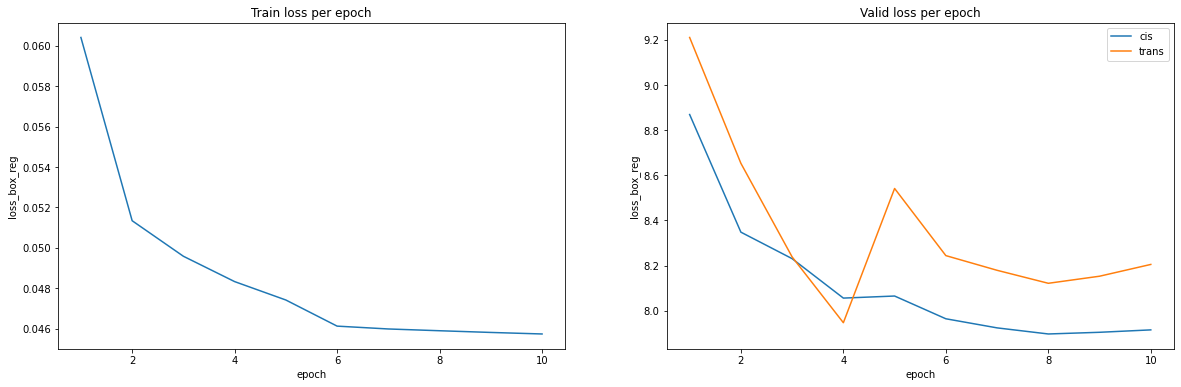

In [57]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1),train_loss_all,label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1),cis_loss_all, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1),trans_loss_all, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

## Predictions

In [88]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

Text(0.5, 1.0, 'After NMS')

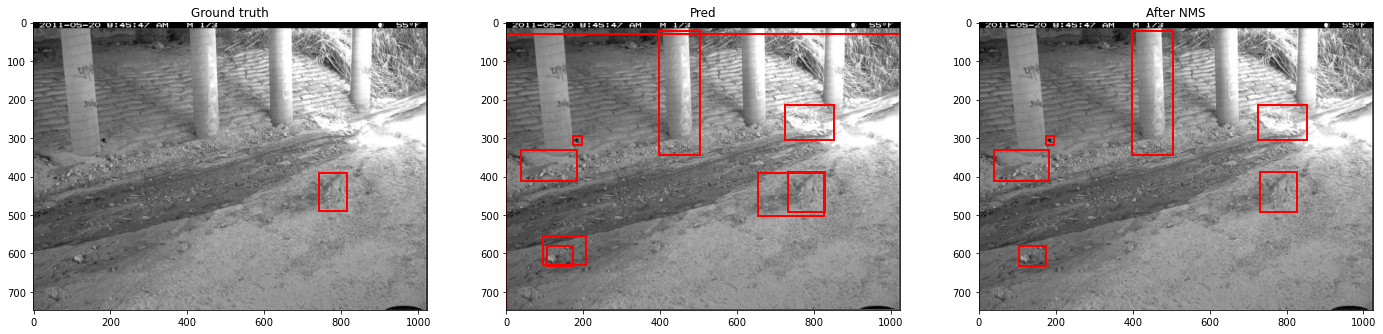

In [89]:
image_i = 1 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                          train_labels[image_i]['boxes'][0][1]), 
                         train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                         train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [90]:
boxes_to_keep

tensor([0, 1, 4, 5, 6, 8])

In [91]:
pred[image_i]['boxes'][0]

tensor([731.9652, 387.7749, 827.5851, 493.2746], device='cuda:0')

In [92]:
train_labels[image_i]['boxes']

tensor([[743., 390., 816., 490.]])

In [ ]:
# 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

In [ ]:
# Evaluate perfo on COCO detection metrics

# takes +- 5min to run on trans_valid

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = trans_valid_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
  images = [image.to(device) for image in images]
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

  with torch.no_grad():

    pred=model(images)

    if apply_nms:
      boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'],pred[0]['scores'],iou_threshold=iou_threshold).cpu()
      pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
      pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
      pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

    outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
    res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

### Metrics

In [ ]:
metric = MeanAveragePrecision(max_detection_thresholds=[2])
metric.update(pred, list(train_labels))
from pprint import pprint
pprint(metric.compute())